# 04. Model Experiment: LightGBM
**Author:** Edsequille Publico
### **Goal**
Compare LightGBM performance against XGBoost.

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4247
[LightGBM] [Info] Number of data points in the train set: 560, number of used features: 26
[LightGBM] [Info] Start training from score 96.069643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

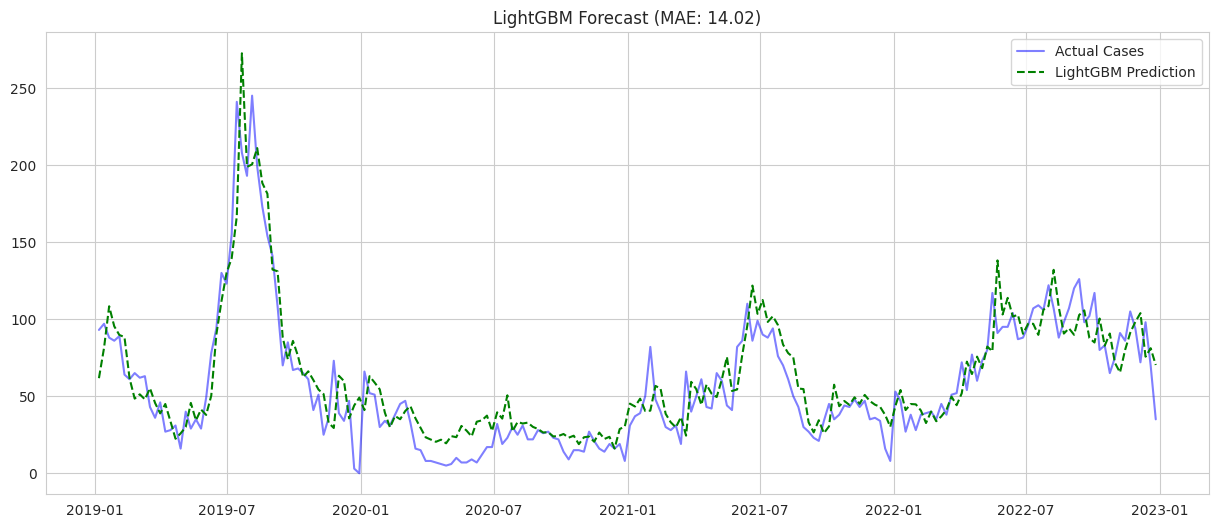

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)

# Load Data
PROCESSED_DIR = '/kaggle/input/dengue-defensor-features'
INPUT_FILE = os.path.join(PROCESSED_DIR, '02_features.csv')
df = pd.read_csv(INPUT_FILE, index_col='date', parse_dates=True)

# Split Data (Same as XGBoost for fair comparison)
SPLIT_DATE = '2019-01-01'
train = df[df.index < SPLIT_DATE]
test = df[df.index >= SPLIT_DATE]

X_train = train.drop(columns=['cases'])
y_train = train['cases']
X_test = test.drop(columns=['cases'])
y_test = test['cases']

# --- LIGHTGBM MODEL ---

# Create Dataset objects for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Hyperparameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,       # Controls complexity
    'learning_rate': 0.05,
    'feature_fraction': 0.9 # Randomly select 90% of features per tree (prevents overfitting)
}

# Train
print("Training LightGBM...")
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)] # Stop if no improvement
)

# Predict
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"\nLightGBM MAE: {mae:.2f}")

# Plot Comparison
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Actual Cases', color='blue', alpha=0.5)
plt.plot(test.index, y_pred, label='LightGBM Prediction', color='green', linestyle='--')
plt.title(f'LightGBM Forecast (MAE: {mae:.2f})')
plt.legend()
plt.show()